# Modelos de Difusión desde Cero

A veces es útil considerar la versión más simple posible de algo para entender mejor cómo funciona. Eso es lo que intentaremos en este notebook, comenzando con un modelo de difusión 'de juguete' para ver cómo funcionan las diferentes piezas, y luego examinando cómo difiere de una implementación más compleja.

Veremos:
- El proceso de corrupción (añadir ruido a los datos)
- Qué es un UNet y cómo implementar uno extremadamente minimalista desde cero
- Entrenamiento de modelos de difusión
- Teoría del muestreo

Luego compararemos nuestras versiones con la implementación DDPM de diffusers, explorando:
- Mejoras sobre nuestro mini UNet
- El planificador de ruido de DDPM
- Diferencias en el objetivo de entrenamiento
- Condicionamiento por timestep
- Métodos de muestreo


También es importante notar que la mayoría del código aquí es solo para fines ilustrativos, y no recomendaría adoptarlo directamente para tu propio trabajo (a menos que solo quieras mejorarlo para fines de aprendizaje).

## Configuración e importaciones:

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Datos

Aquí vamos a probar todo con un conjunto de datos muy pequeño: MNIST. Si quieres darle al modelo un reto un poco mayor sin cambiar nada más, `torchvision.datasets.FashionMNIST` debería funcionar como reemplazo directo.

In [3]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 248kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.49MB/s]


In [4]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([9, 9, 5, 8, 6, 9, 6, 9])


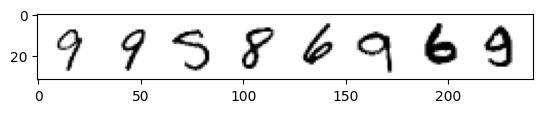

In [5]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

Cada imagen es un dibujo en escala de grises de 28x28 píxeles de un dígito, con valores que van de 0 a 1.

## El Proceso de Corrupción

Supón que no sabes nada sobre modelos de difusión, pero sabes que el proceso implica añadir ruido. ¿Cómo lo harías?

Probablemente queremos una forma sencilla de controlar la cantidad de corrupción. ¿Y si tomamos un parámetro para la `cantidad` de ruido a añadir, y luego hacemos:

`noise = torch.rand_like(x)`

`noisy_x =  (1-cantidad)*x + cantidad*noise`

Si cantidad = 0, obtenemos la entrada sin cambios. Si cantidad llega a 1, obtenemos solo ruido sin rastro de la entrada x. Al mezclar la entrada con ruido de esta manera, mantenemos la salida en el mismo rango (0 a 1).

Podemos implementar esto fácilmente (solo cuida las formas para no tener problemas con broadcasting):

In [6]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

Y visualizando los resultados para ver que funciona como esperamos:

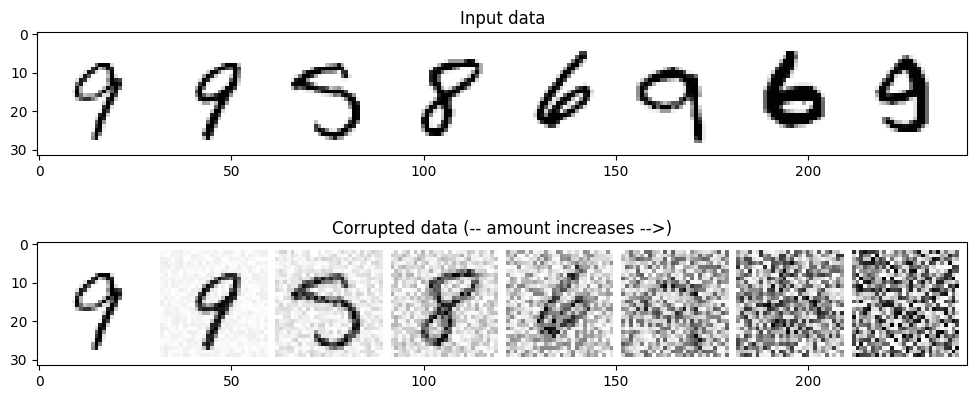

In [7]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

A medida que la cantidad de ruido se acerca a uno, nuestros datos empiezan a parecerse a ruido puro. Pero para la mayoría de los niveles de ruido, aún puedes adivinar el dígito bastante bien. ¿Crees que esto es óptimo?

## Modelo

Queremos un modelo que reciba imágenes ruidosas de 28px y produzca una predicción de la misma forma. Una elección popular aquí es una arquitectura llamada UNet. [Originalmente inventada para tareas de segmentación en imágenes médicas](https://arxiv.org/abs/1505.04597), un UNet consiste en un 'camino de contracción' donde los datos se comprimen y un 'camino de expansión' donde se expanden de nuevo a la dimensión original (similar a un autoencoder), pero también cuenta con conexiones de salto que permiten que la información y los gradientes fluyan a diferentes niveles.

Algunos UNet tienen bloques complejos en cada etapa, pero para esta demostración construiremos un ejemplo mínimo que recibe una imagen de un canal y la pasa por tres capas convolucionales en el camino descendente (down_layers en el diagrama y código) y tres en el camino ascendente, con conexiones de salto entre las capas descendentes y ascendentes. Usaremos max pooling para reducir y `nn.Upsample` para aumentar la resolución, en lugar de capas aprendibles como en UNet más complejos. Aquí tienes la arquitectura mostrando el número de canales en la salida de cada capa:

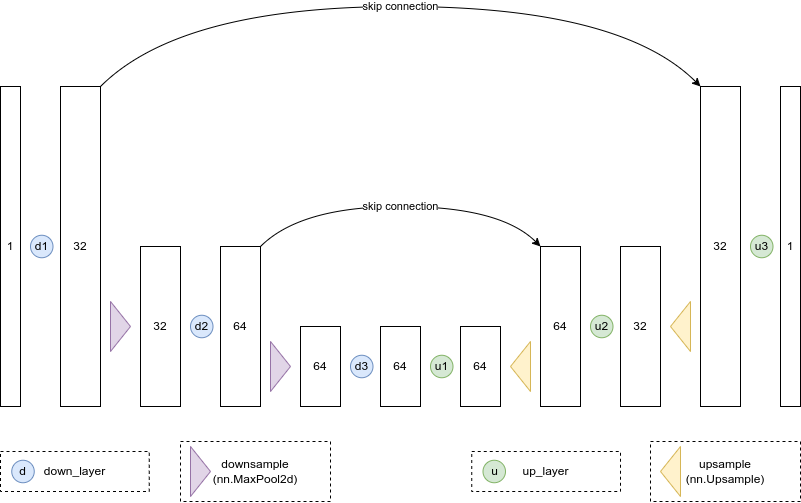

Así se ve eso en código:

In [8]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

Podemos verificar que la forma de salida es la misma que la de entrada, como esperamos:

In [9]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

Esta red tiene poco más de 300,000 parámetros:

In [10]:
sum([p.numel() for p in net.parameters()])

309057

Puedes probar cambiando el número de canales en cada capa o probando diferentes arquitecturas si lo deseas.

## Entrenando la red

Entonces, ¿qué debería hacer exactamente el modelo? De nuevo, hay varias formas de verlo, pero para esta demo elijamos un enfoque simple: dado un input corrupto `noisy_x`, el modelo debe predecir lo mejor posible cómo se veía el x original. Compararemos esto con el valor real usando el error cuadrático medio (MSE).

Ahora podemos intentar entrenar la red.
- Obtener un lote de datos
- Corromperlo con cantidades aleatorias
- Pasarlo por el modelo
- Comparar las predicciones del modelo con las imágenes limpias para calcular la pérdida
- Actualizar los parámetros del modelo en consecuencia

¡Siéntete libre de modificar esto y ver si puedes mejorarlo!

Finished epoch 0. Average loss for this epoch: 0.026249
Finished epoch 1. Average loss for this epoch: 0.020326
Finished epoch 2. Average loss for this epoch: 0.018528


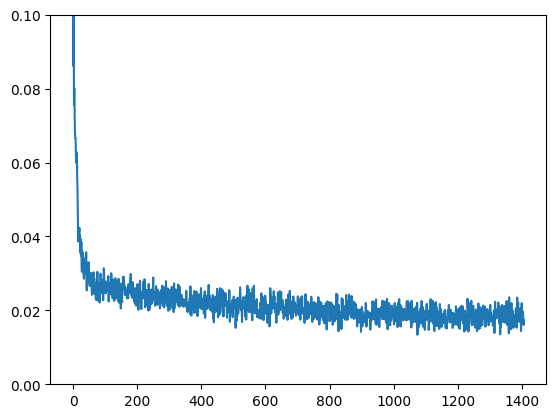

In [11]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

Podemos intentar ver cómo se ven las predicciones del modelo tomando un lote de datos, corrompiéndolo con diferentes cantidades y luego viendo las predicciones del modelo:

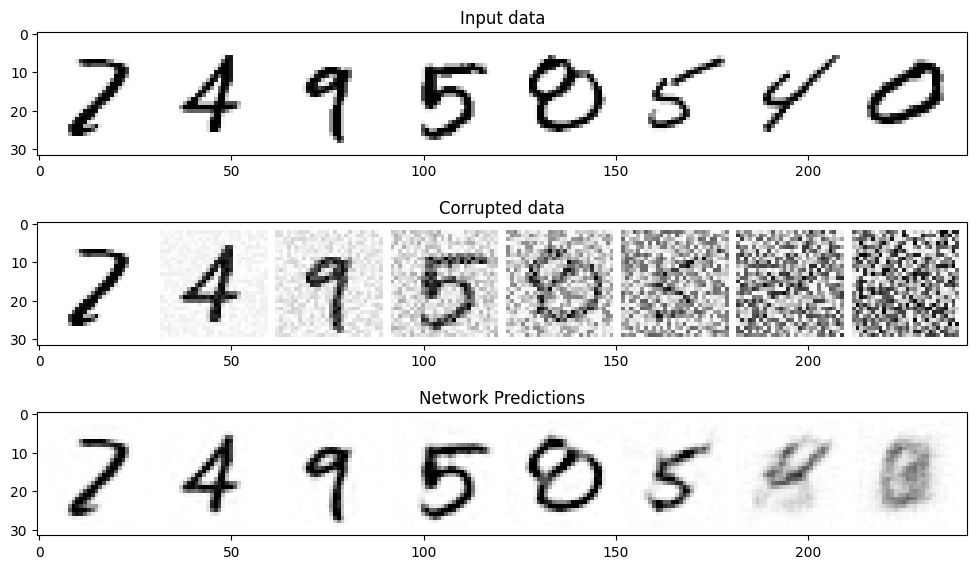

In [12]:
#@markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

¡Puedes ver que para niveles bajos de ruido las predicciones son bastante buenas! Pero a medida que el nivel aumenta, hay menos información para el modelo, y cuando llegamos a cantidad=1, la salida es una imagen borrosa cercana a la media del conjunto de datos, intentando adivinar cómo podría ser la salida...

## Muestreo

Si nuestras predicciones con altos niveles de ruido no son muy buenas, ¿cómo generamos imágenes?

Bueno, ¿y si partimos de ruido aleatorio, miramos las predicciones del modelo pero solo avanzamos un poco hacia esa predicción, digamos, un 20% del camino? Ahora tenemos una imagen muy ruidosa en la que quizás hay un poco de estructura, que podemos volver a pasar por el modelo para obtener una nueva predicción. La esperanza es que esta nueva predicción sea un poco mejor que la anterior (ya que el punto de partida es menos ruidoso) y así podemos dar otro pequeño paso con esta nueva predicción mejorada.

Repite unas cuantas veces y (si todo va bien) ¡obtenemos una imagen! Aquí se ilustra ese proceso en solo 5 pasos, visualizando la entrada al modelo (izquierda) y las imágenes denoised predichas (derecha) en cada etapa. Nota que aunque el modelo predice la imagen denoised incluso en el paso 1, solo avanzamos una parte del camino. En unos pocos pasos las estructuras aparecen y se refinan, hasta obtener nuestras salidas finales.

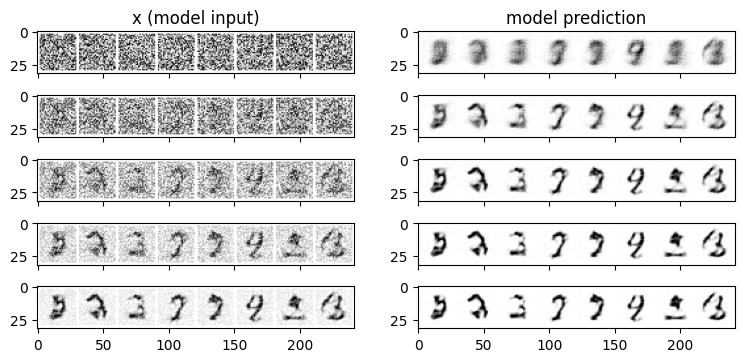

In [13]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

Podemos dividir el proceso en más pasos y esperar mejores imágenes de esa manera:

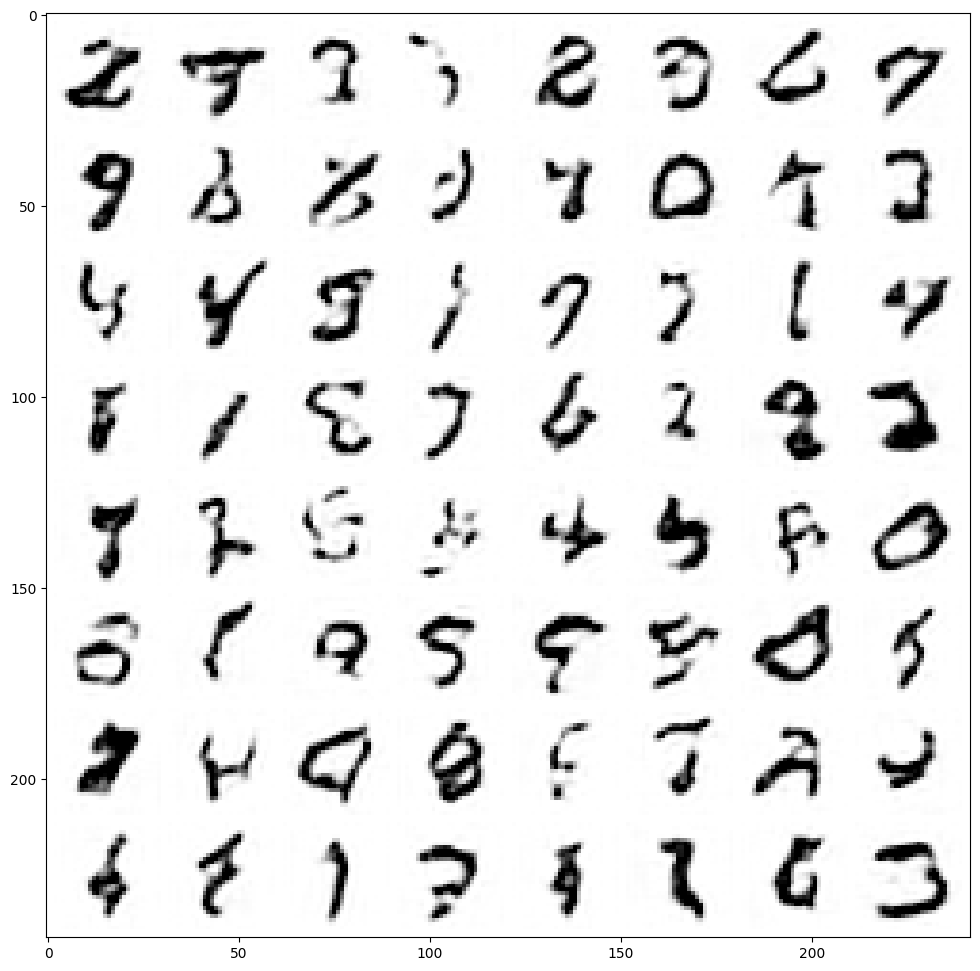

In [14]:
#@markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

¡No es perfecto, pero hay algunos dígitos reconocibles! Puedes experimentar entrenando por más tiempo (por ejemplo, 10 o 20 épocas) y ajustando la configuración del modelo, la tasa de aprendizaje, el optimizador, etc. Además, recuerda que FashionMNIST es un reemplazo de una línea si quieres un conjunto de datos un poco más difícil.

## Comparación con DDPM


*   El modelo `UNet2DModel` de diffusers es más avanzado que nuestro BasicUNet
*   El proceso de corrupción se maneja de forma diferente
*   El objetivo de entrenamiento es diferente, involucrando predecir el ruido en vez de la imagen denoised
*   El modelo se condiciona en la cantidad de ruido presente mediante el timestep, que se pasa como argumento adicional al método forward.
*   Hay varios métodos de muestreo disponibles, que deberían funcionar mejor que nuestra versión simplificada.

Han surgido muchas mejoras desde que salió el paper de DDPM, pero este ejemplo es útil para entender las diferentes decisiones de diseño posibles. Si te interesa profundizar, puedes leer el paper ['Elucidating the Design Space of Diffusion-Based Generative Models'](https://arxiv.org/abs/2206.00364), que explora todos estos componentes en detalle y hace nuevas recomendaciones para obtener el mejor rendimiento.

### El UNet

El modelo UNet2DModel de diffusers tiene varias mejoras sobre nuestro BasicUNet:

*   GroupNorm aplica normalización por grupos a las entradas de cada bloque
*   Capas de Dropout para un entrenamiento más estable
*   Múltiples capas resnet por bloque (si layers_per_block no es 1)
*   Atención (usualmente solo en bloques de baja resolución)
*   Condicionamiento por timestep
*   Bloques de reducción y aumento de resolución con parámetros aprendibles

Vamos a crear e inspeccionar un UNet2DModel:



In [15]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

¡Como puedes ver, hay mucho más en juego! Además, tiene significativamente más parámetros que nuestro BasicUNet:

In [16]:
sum([p.numel() for p in model.parameters()]) # 1.7M vs the ~309k parameters of the BasicUNet

1707009

Podemos replicar el entrenamiento mostrado arriba usando este modelo en lugar del original. Debemos pasar tanto x como el timestep al modelo (aquí siempre paso t=0 para mostrar que funciona sin este condicionamiento y para mantener el código de muestreo sencillo, pero también puedes probar pasando `(amount*1000)` para obtener un timestep equivalente a la cantidad de corrupción). Las líneas cambiadas están marcadas con `#<<<` si quieres inspeccionar el código.

Finished epoch 0. Average loss for this epoch: 0.020562
Finished epoch 1. Average loss for this epoch: 0.013336
Finished epoch 2. Average loss for this epoch: 0.011757


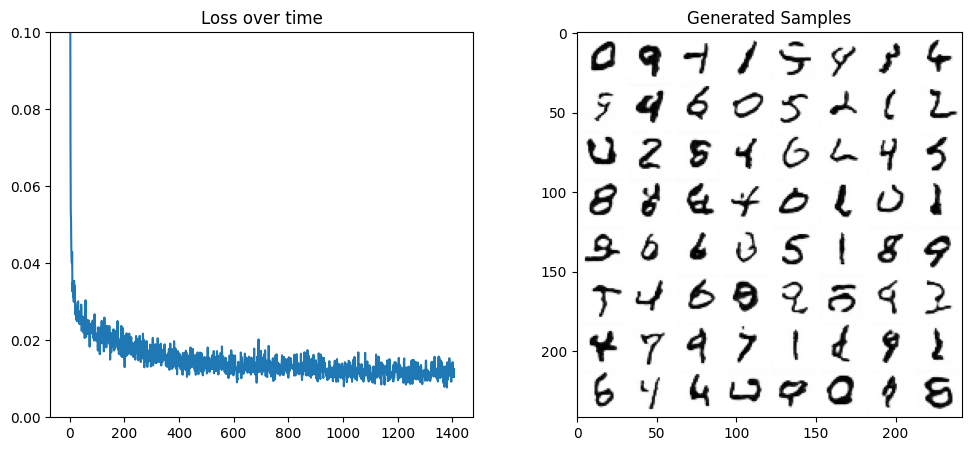

In [17]:
#@markdown Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples')

¡Esto se ve mucho mejor que nuestro primer conjunto de resultados! Puedes probar ajustando la configuración del unet o entrenando por más tiempo para obtener un rendimiento aún mejor.

### El Proceso de Corrupción

El paper de DDPM describe un proceso de corrupción que añade una pequeña cantidad de ruido en cada 'timestep'. Dado $x_{t-1}$ para algún timestep, podemos obtener la siguiente versión (un poco más ruidosa) $x_t$ con:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>

Es decir, tomamos $x_{t-1}$, lo escalamos por $\sqrt{1 - \beta_t}$ y añadimos ruido escalado por $\beta_t$. Este $\beta$ se define para cada t según un calendario, y determina cuánto ruido se añade por paso. Ahora, no necesariamente queremos hacer esta operación 500 veces para obtener $x_{500}$, así que hay otra fórmula para obtener $x_t$ para cualquier t dado $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ donde $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ y $\alpha_i = 1-\beta_i$<br><br>

¡La notación matemática siempre parece intimidante! Por suerte, el scheduler se encarga de todo eso (descomenta la siguiente celda para ver el código). Podemos graficar $\sqrt{\bar{\alpha}_t}$ (etiquetado como `sqrt_alpha_prod`) y $\sqrt{(1 - \bar{\alpha}_t)}$ (etiquetado como `sqrt_one_minus_alpha_prod`) para ver cómo la entrada (x) y el ruido se escalan y mezclan en diferentes timesteps:


In [ ]:
#??noise_scheduler.add_noise

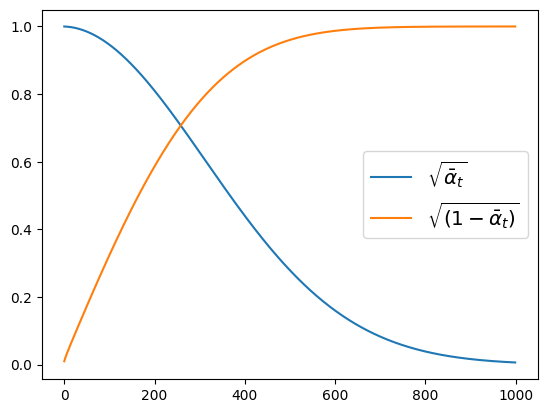

In [18]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

Inicialmente, el x ruidoso es mayormente x (sqrt_alpha_prod ~= 1), pero con el tiempo la contribución de x disminuye y la del ruido aumenta. A diferencia de nuestra mezcla lineal de x y ruido según `amount`, aquí se vuelve ruidoso relativamente rápido. Podemos visualizar esto en algunos datos:

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


Text(0.5, 1.0, 'Noisy X')

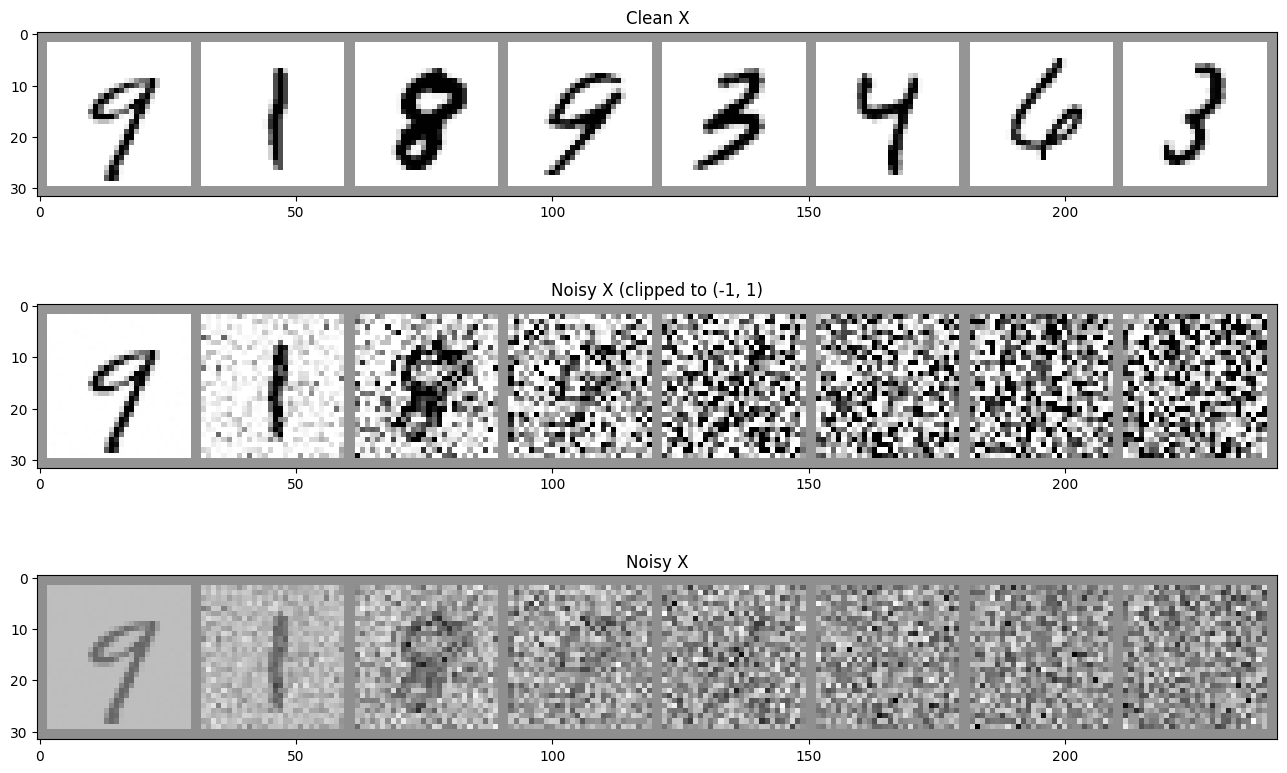

In [19]:
#@markdown visualize the DDPM noising process for different timesteps:

# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X')

Otra diferencia importante: la versión DDPM añade ruido tomado de una distribución Gaussiana (media 0, desviación estándar 1 usando torch.randn) en vez del ruido uniforme entre 0 y 1 (de torch.rand) que usamos en nuestra función `corrupt` original. En general, también tiene sentido normalizar los datos de entrenamiento. En el otro notebook verás `Normalize(0.5, 0.5)` en la lista de transformaciones, que mapea los datos de imagen de (0, 1) a (-1, 1) y es 'suficientemente bueno' para nuestros propósitos. No lo hicimos aquí, pero la celda de visualización anterior lo añade para un escalado y visualización más precisos.

### Objetivo de Entrenamiento

En nuestro ejemplo de juguete, el modelo intentaba predecir la imagen denoised. En DDPM y muchas otras implementaciones de modelos de difusión, el modelo predice el ruido usado en el proceso de corrupción (antes de escalar, así que es ruido de varianza unitaria). En código, se ve así:

```python
noise = torch.randn_like(xb) # << NB: randn no rand
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = mse_loss(model_prediction, noise) # el ruido es el objetivo
```

Podrías pensar que predecir el ruido (a partir del cual podemos derivar la imagen denoised) es equivalente a predecir directamente la imagen denoised. Entonces, ¿por qué preferir uno sobre el otro? ¿Es solo por conveniencia matemática?

Resulta que hay otra sutileza aquí. Calculamos la pérdida en diferentes (aleatorios) timesteps durante el entrenamiento. Estos diferentes objetivos llevan a diferentes 'ponderaciones implícitas' de las pérdidas, donde predecir el ruido da más peso a los niveles bajos de ruido. Puedes elegir objetivos más complejos para cambiar esta 'ponderación implícita'. O quizás eliges un calendario de ruido que resulta en más ejemplos con alto nivel de ruido. Quizás haces que el modelo prediga una 'velocidad' v que definimos como una combinación de la imagen y el ruido dependiendo del nivel de ruido (ver 'PROGRESSIVE DISTILLATION FOR FAST SAMPLING OF DIFFUSION MODELS'). Quizás haces que el modelo prediga el ruido pero luego escalas la pérdida por algún factor dependiente de la cantidad de ruido basado en teoría (ver 'Perception Prioritized Training of Diffusion Models') o en experimentos para ver qué niveles de ruido son más informativos para el modelo (ver 'Elucidating the Design Space of Diffusion-Based Generative Models'). Resumiendo: elegir el objetivo afecta el rendimiento del modelo, y la investigación sigue en curso para encontrar la mejor opción.

Actualmente, predecir el ruido (epsilon o eps en algunos lugares) es el enfoque preferido, pero con el tiempo probablemente veremos otros objetivos soportados en la librería y usados en diferentes situaciones.



### Condicionamiento por Timestep

El modelo UNet2DModel recibe tanto x como el timestep. Este último se convierte en un embedding y se introduce en el modelo en varios lugares.

La teoría detrás de esto es que, al darle al modelo información sobre el nivel de ruido, puede realizar mejor su tarea. Aunque es posible entrenar un modelo sin este condicionamiento, parece ayudar al rendimiento en algunos casos y la mayoría de las implementaciones lo incluyen, al menos en la literatura actual.

### Muestreo

Dado un modelo que estima el ruido presente en una entrada ruidosa (o predice la versión denoised), ¿cómo producimos nuevas imágenes?

Podríamos alimentar solo ruido y esperar que el modelo prediga una buena imagen denoised en un solo paso. Sin embargo, como vimos en los experimentos anteriores, esto normalmente no funciona bien. Así que, en su lugar, damos varios pasos pequeños basados en la predicción del modelo, eliminando iterativamente un poco del ruido cada vez.

La forma exacta de dar estos pasos depende del método de muestreo usado. No entraremos en la teoría en detalle, pero algunas preguntas clave de diseño son:
- ¿Qué tan grande debe ser cada paso? Es decir, ¿qué 'calendario de ruido' debes seguir?
- ¿Usas solo la predicción actual del modelo para informar el paso (como DDPM, DDIM y muchos otros)? ¿Evalúas el modelo varias veces para estimar gradientes de orden superior para un paso más grande y preciso (métodos de orden superior y algunos ODE solvers)? ¿O mantienes un historial de predicciones pasadas para informar mejor el paso actual (muestreadores lineales multi-step y ancestrales)?
- ¿Añades ruido adicional (a veces llamado churn) para añadir más aleatoriedad al proceso de muestreo, o lo mantienes completamente determinista? Muchos muestreadores controlan esto con un parámetro (como 'eta' para muestreadores DDIM) para que el usuario elija.

La investigación sobre métodos de muestreo para modelos de difusión avanza rápidamente, y cada vez se proponen más métodos para encontrar buenas soluciones en menos pasos. Los curiosos pueden explorar el código de las diferentes implementaciones disponibles en la librería diffusers [aquí](https://github.com/huggingface/diffusers/tree/main/src/diffusers/schedulers) o consultar la [documentación](https://huggingface.co/docs/diffusers/api/schedulers/overview), que suele enlazar a los artículos relevantes.

## Conclusiones

Esperamos que esto haya sido una forma útil de ver los modelos de difusión desde una perspectiva diferente.